In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import re

from IPython.display import display
pd.options.display.max_columns = 500

### Creating a function to save as csv

In [38]:
def predict_tocsv(yhat_test):
    predicted = pd.DataFrame({"Id": np.arange(1461,2920), "SalePrice": yhat_test})
    return predicted.to_csv("./predicted.csv", index=False)

## Import data set

In [2]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Outliers

* We need to add justification

In [4]:
# remove outliers
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]

In [5]:
train = train[~((train['MasVnrArea'] > 1400) & (train['SalePrice'] < 300000))]

In [6]:
train = train[~((train['LotFrontage'] > 300) & (train['SalePrice'] < 300000 ))]

In [7]:
train = train[~((train['LotArea'] > 200000) & (train['SalePrice'] < 500000 ))]

In [8]:
# train = train[~((train['YearBuilt'] < 1900) & (train['SalePrice'] > 400000))]

In [9]:
train = train[~((train['OpenPorchSF'] > 500) & (train['SalePrice'] < 100000))]

In [10]:
# train.drop('TotalBsmtSF', axis= 1, inplace=True)
# test.drop('TotalBsmtSF', axis= 1, inplace=True)


# train['TwoStory'] = train['2ndFlrSF'].isna().apply(lambda x: int(not x))
# test['TwoStory'] = test['2ndFlrSF'].isna().apply(lambda x: int(not x))

# train['SF'] = train['1stFlrSF'] + train['2ndFlrSF']
# train.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)

# test['SF'] = test['1stFlrSF'] + test['2ndFlrSF']
# test.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)


## Remove SalePrice and Id

In [11]:
response_variable = np.log1p(train.SalePrice)
id_ = test.Id
train = train.loc[:,'MSSubClass':'SaleCondition']
test = test.loc[:,'MSSubClass':'SaleCondition']

## Multicoliearity 

We need to add justification

In [12]:
# drop some features to avoid multicollinearity
train.drop(['GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)
test.drop(['GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)

## Skewdness

In [13]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

Try different values

In [14]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.65]
skewed_feats = skewed_feats.index

train[skewed_feats] = boxcox1p(train[skewed_feats], 0.15)
test[skewed_feats] = boxcox1p(test[skewed_feats], 0.15)

## Dummification

In [15]:
train = pd.get_dummies(train)
train = train.fillna(train.mean())

In [16]:
test = test.fillna(test.mean())

In [17]:
test = pd.get_dummies(test)

In [18]:
train_cols = set(train.columns)
test_cols = set(test.columns)

test_drop =  list(test_cols - train_cols)
test_unkonwn_dummies = list(train_cols - test_cols)

In [19]:
test_dummies2 = test.reindex(columns=test_unkonwn_dummies, fill_value=0)

In [20]:
test = pd.concat([test, test_dummies2], axis=1)

In [21]:
test = test[train.columns]

In [22]:
train['SalePrice'] = response_variable

# Feature Engineering

## Age

In [23]:
# Yb = train_df['YearBuilt']

# range_bins = [(1800,1900), (1900,1910), (1910,1920), (1920,1930), (1930,1940), (1940,1950), (1950,1960), (1960,1970), (1970,1980), (1980,1990), (1990,2000), (2000,2011)]

# bins = {r:x for (x,y) in range_bins for r in range(x,y)}

# train_df = pd.concat([train_df.drop('YearBuilt', axis=1), Yb.map(bins)], axis=1)
# Yb = test_df['YearBuilt']

# test = pd.concat([test.drop('YearBuilt', axis=1), Yb.map(bins)], axis=1)


In [24]:
# train[['Age']] = train[['YearBuilt']].apply(lambda x: x.max() - x)
# train = train.drop('YearBuilt', axis=1)
# test[['Age']] = test[['YearBuilt']].apply(lambda x: x.max() - x)
# test = test.drop('YearBuilt', axis=1)

## Garage Age

In [25]:
# test['GarageYrBlt'] = test['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [26]:
# train['GarageYrBlt'] = train['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [27]:
# train['GarageYrBlt'] = train['YrSold'] - train['GarageYrBlt']

In [28]:
# test['GarageYrBlt'] = test['YrSold'] - test['GarageYrBlt']

## YearRemodAdd

In [29]:
# train['YearRemodAdd']  = (train['YrSold'] - train['YearRemodAdd'])
# test['YearRemodAdd']  = (test['YrSold'] - test['YearRemodAdd'])

In [30]:
# train.to_pickle('train.pkl')
# test.to_pickle('test.pkl')

In [31]:
# cont = train.T[np.array(train.nunique() > 70)].T.columns.drop('SalePrice')
# scale = StandardScaler()
# train[cont] = scale.fit_transform(train[cont])

# cont = test.T[np.array(test.nunique() > 70)].T.columns
# scale = StandardScaler()
# test[cont] = scale.fit_transform(test[cont])

## Train Test Split

In [32]:
#split
X_train = train.drop('SalePrice', axis=1)
X_test = test
y_train = response_variable

## Modeling

<b> Lasso Grid </b>

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=5000)

alphas = [.0004] #np.logspace(-4, -2, 100)

grid_lasso = GridSearchCV(estimator=lasso,
    param_grid=dict(alpha=alphas), cv=10, scoring='neg_mean_squared_error')

grid_lasso.fit(X_train, y_train)

y_hats = grid_lasso.best_estimator_.predict(X_train)
test_predictions = np.expm1(grid_lasso.best_estimator_.predict(X_test))

grid_lasso.best_estimator_.fit(X_train, y_train)
grid_lasso.best_estimator_.score(X_train, y_train)
grid_lasso.best_estimator_

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
np.sqrt(-grid_lasso.cv_results_["mean_test_score"])

array([0.1089201])

<b> Ridge Grid </b>

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge(max_iter=5000)

alphas = [i for i in range(1,20)]
grid_ridge = GridSearchCV(estimator=ridge,
    param_grid=dict(alpha=alphas), cv=10, scoring='neg_mean_squared_error')

grid_ridge.fit(X_train, y_train)

y_hats = grid_ridge.best_estimator_.predict(X_train)
test_predictions = np.expm1(grid_ridge.best_estimator_.predict(X_test))

grid_ridge.best_estimator_.fit(X_train, y_train)
grid_ridge.best_estimator_.score(X_train, y_train)
grid_ridge.best_estimator_

Ridge(alpha=9, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [109]:
print(grid_ridge.best_params_, grid_ridge.best_score_)

{'alpha': 0.1} -0.013669821637574131


<b> Elastic Net </b>

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(max_iter=5000)

alphas = [i/10000 for i in range(5,15)] 

grid_elastic = GridSearchCV(estimator=elastic,
    param_grid=dict(alpha=alphas), scoring='neg_mean_squared_error')

grid_elastic.fit(X_train, y_train)

y_hats = grid_elastic.best_estimator_.predict(X_train)
test_predictions = np.expm1(grid_elastic.best_estimator_.predict(X_test))

grid_elastic.best_estimator_.fit(X_train, y_train)
grid_elastic.best_estimator_.score(X_train, y_train)
grid_elastic.best_estimator_

ElasticNet(alpha=0.0009, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

<b> Random Forest </b>

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_param = {
    "n_estimators": np.linspace(start=100, stop=1000, num=10, dtype=int)
}

rf = RandomForestRegressor(oob_score=True, min_samples_leaf=2, min_samples_split=2, random_state=100)
grid_rf = GridSearchCV(rf, rf_param, n_jobs=-1)

## Prediciton

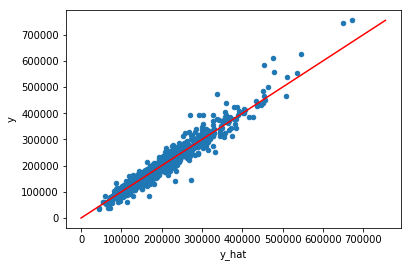

In [34]:
true_line = np.linspace(0, np.expm1(y_train.max()), 50)

pd.DataFrame({'y_hat': np.expm1(y_hats), 'y': np.expm1(y_train)}).plot(
    kind='scatter', x='y_hat', y='y').plot(true_line,
    true_line,  c='red')

In [35]:
coef_df = pd.DataFrame({'cols': X_train.columns,'coef': grid.best_estimator_.coef_}, index=X_train.columns )

Cross Validation Scores

In [37]:
#cross validation scores

from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

0.2557327002851105

In [47]:
print("Lasso RMSE: %0.4f" %rmsle_cv(grid_lasso).mean())

Lasso RMSE: 0.1098


In [116]:
print("Ridge RMSE: %0.4f" %rmsle_cv(grid_ridge).mean())

Ridge RMSE: 0.1124


In [94]:
print("Elastic Net RMSE: %0.4f" %rmsle_cv(grid_elastic).mean())

Elastic Net RMSE: 0.1100


In [83]:
print("Random Forest RMSE: %0.4f" %rmsle_cv(grid_rf).mean())

Random Forest RMSE: 0.1356


In [95]:
print("Random XGBoost RMSE: %0.4f" %np.sqrt(0.03222367061104697))

Random Forest RMSE: 0.1795


### Plotting Alphas

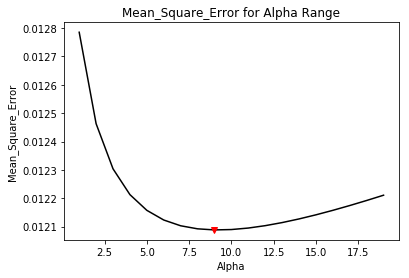

In [134]:
#Ridge
alphas = [i for i in range(1,20)]

plt.plot(alphas, (-1*grid_ridge.cv_results_['mean_test_score']), 'k', grid_ridge.best_params_["alpha"], -grid_ridge.best_score_, 'rv')
plt.title('Mean_Square_Error for Alpha Range')
plt.ylabel('Mean_Square_Error')
plt.xlabel('Alpha')
plt.show()

In [137]:
grid_elastic.cv_results_["mean_test_score"]

array([-0.01296263, -0.0126458 , -0.01248483, -0.01239342, -0.01238048,
       -0.01240048, -0.01242409, -0.01245696, -0.01251272, -0.0125931 ,
       -0.01259326, -0.0124403 , -0.01247008, -0.01253625, -0.01267156,
       -0.01287953, -0.01312843, -0.01332371, -0.01349828, -0.01366834,
       -0.01252608, -0.01253307, -0.01266699, -0.01293927, -0.0132784 ,
       -0.01353508, -0.01379328, -0.01406802, -0.0143821 , -0.01464742,
       -0.01252869, -0.01267131, -0.01299637, -0.01340794, -0.01374436,
       -0.01410466, -0.01452113, -0.01485491, -0.01519844, -0.0155644 ,
       -0.0125888 , -0.01286943, -0.01336577, -0.01378231, -0.01423947,
       -0.01473295, -0.01515211, -0.01560787, -0.01597392, -0.01627943,
       -0.01268413, -0.01310814, -0.01365328, -0.01417764, -0.01477273,
       -0.01528049, -0.01580855, -0.01619323, -0.0165466 , -0.01687231,
       -0.01276682, -0.01335781, -0.01394343, -0.01462211, -0.01523117,
       -0.01584663, -0.01628964, -0.01668957, -0.01706447, -0.01

In [139]:
alphas

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

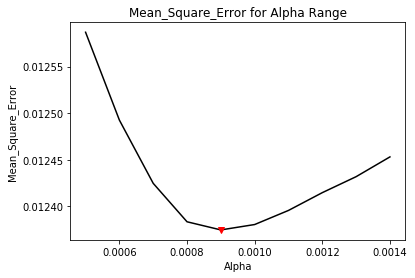

In [147]:
#Elastic Net
alphas = [i/10000 for i in range(5,15)]

plt.plot(alphas, (-1*grid_elastic.cv_results_['mean_test_score']), 'k', grid_elastic.best_params_["alpha"], -grid_elastic.best_score_, 'rv')
plt.title('Mean_Square_Error for Alpha Range')
plt.ylabel('Mean_Square_Error')
plt.xlabel('Alpha')
plt.show()